# Section: Securing Federated Learning

- Lesson 1: Trusted Aggregator
- Lesson 2: Intro to Additive Secret Sharing
- Lesson 3: Intro to Fixed Precision Encoding
- Lesson 4: Secret Sharing + Fixed Precision in PySyft
- Final Project: Federated Learning wtih Encrypted Gradient Aggregation

# Lesson: Federated Learning with a Trusted Aggregator

In the last section, we learned how to train a model on a distributed dataset using Federated Learning. In particular, the last project aggregated gradients directly from one data owner to another. 

However, while in some cases it could be ideal to do this, what would be even better is to be able to choose a neutral third party to perform the aggregation.

As it turns out, we can use the same tools we used previously to accomplish this.

# Project: Federated Learning with a Trusted Aggregator

In [10]:
import torch
from torch import optim, nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.datasets as torch_datasets

In [12]:
import syft as sy
hook = sy.TorchHook(torch)

In [14]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_trainset = torch_datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [ ]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # flatten
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [ ]:
def create_workers(num_workers):
    return [sy.VirtualWorker(hook, id=f"worker_{i}") for i in range(num_workers)]

In [ ]:
def send_train_data_to_workers(workers, trainset, batch_size):
    data_per_worker = len(trainset) // len(workers)
    
    worker_data = []
    for i, worker in enumerate(workers):
        lo = i * data_per_worker
        hi = lo + data_per_worker
        
        data, targets = (d[lo:hi].send(worker) for d in (trainset.data, trainset.targets))
        batched_data = torch.split(data, batch_size)
        batched_targets = torch.split(targets, batch_size)
        worker_data.append(list(zip(batched_data, batched_targets)))
    
    return worker_data

In [ ]:
def train_federated(trainset, num_workers=10, epochs=5, batch_size=64):
    manager = sy.VirtualWorker(hook, id="manager")
    workers = create_workers(num_workers)
    worker_data = send_train_data_to_workers(workers, trainset, batch_size)
    
    model = MNISTClassifier()
    criterion = nn.NLLLoss()
        
    for e in range(epochs):
        models  = [model.copy().send(worker) for worker in workers]
        optimizers = [optim.Adam(model.parameters(), lr=0.003) for model in models]
        
        mean_loss = 0
        
        for i, worker in enumerate(worker_data):
            model = models[i]
            optimizer = optimizers[i]
            
            # batches
            for images, labels in worker:
                optimizer.zero_grad()

                log_ps = model(images.float())
                loss = criterion(log_ps, labels)
                loss.backward()
                optimizer.step()
                
                mean_loss += (loss.get().item() / len(worker_data))
                
        for model in models:
            model.move(manager)

        with torch.no_grad():
            fc_layers = ("fc1", "fc2", "fc3", "fc4")
            
            for layer in fc_layers:
                weights = torch.stack([getattr(m, layer).weight for m in models])
                biases = torch.stack([getattr(m, layer).bias for m in models])

                mean_weight = torch.mean(weights).get()
                mean_bias = torch.mean(biases).get()
                
                model_layer = getattr(model, layer)
                model_layer.weight.set_(mean_weight)
                model_layer.bias.set_(mean_bias)
                
        model = model.get()

        print("Epoch: {:0>2d}/{:0>2d} | ".format(e+1, epochs),
              "Mean training Loss: {:.3f} ".format(mean_loss))

In [ ]:
train_federated(mnist_trainset)

# Lesson: Intro to Additive Secret Sharing

While being able to have a trusted third party to perform the aggregation is certainly nice, in an ideal setting we wouldn't have to trust anyone at all. This is where Cryptography can provide an interesting alterantive. 

Specifically, we're going to be looking at a simple protocol for Secure Multi-Party Computation called Additive Secret Sharing. This protocol will allow multiple parties (of size 3 or more) to aggregate their gradients without the use of a trusted 3rd party to perform the aggregation. In other words, we can add 3 numbers together from 3 different people without anyone ever learning the inputs of any other actors.

Let's start by considering the number 5, which we'll put into a varible x

In [13]:
x = 5

Let's say we wanted to SHARE the ownership of this number between two people, Alice and Bob. We could split this number into two shares, 2, and 3, and give one to Alice and one to Bob

In [14]:
bob_x_share = 2
alice_x_share = 3

decrypted_x = bob_x_share + alice_x_share
decrypted_x

5

Note that neither Bob nor Alice know the value of x. They only know the value of their own SHARE of x. Thus, the true value of X is hidden (i.e., encrypted). 

The truly amazing thing, however, is that Alice and Bob can still compute using this value! They can perform arithmetic over the hidden value! Let's say Bob and Alice wanted to multiply this value by 2! If each of them multiplied their respective share by 2, then the hidden number between them is also multiplied! Check it out!

In [15]:
bob_x_share = 2 * 2
alice_x_share = 3 * 2

decrypted_x = bob_x_share + alice_x_share
decrypted_x

10

This even works for addition between two shared values!!

In [5]:
# encrypted "5"
bob_x_share = 2
alice_x_share = 3

# encrypted "7"
bob_y_share = 5
alice_y_share = 2

# encrypted 5 + 7
bob_z_share = bob_x_share + bob_y_share
alice_z_share = alice_x_share + alice_y_share

decrypted_z = bob_z_share + alice_z_share
decrypted_z

12

As you can see, we just added two numbers together while they were still encrypted!!!

One small tweak - notice that since all our numbers are positive, it's possible for each share to reveal a little bit of information about the hidden value, namely, it's always greater than the share. Thus, if Bob has a share "3" then he knows that the encrypted value is at least 3.

This would be quite bad, but can be solved through a simple fix. Decryption happens by summing all the shares together MODULUS some constant. I.e.

In [6]:
x = 5

Q = 23740629843760239486723

bob_x_share = 23552870267 # <- a random number
alice_x_share = Q - bob_x_share + x
alice_x_share

23740629843736686616461

In [7]:
bob_x_share % Q

23552870267

In [8]:
alice_x_share % Q

23740629843736686616461

In [18]:
(bob_x_share + alice_x_share) % Q

5

So now, as you can see, both shares are wildly larger than the number being shared, meaning that individual shares no longer leak this inforation. However, all the properties we discussed earlier still hold! (addition, encryption, decryption, etc.)

# Project: Build Methods for Encrypt, Decrypt, and Add 

In this project, you must take the lessons we learned in the last section and write general methods for encrypt, decrypt, and add. Store shares for a variable in a tuple like so.

In [12]:
import random

In [13]:
Q = 23740629843760239486723

In [41]:
def encrypt(x, num_shares=2):
    shares = [random.randint(0, Q) for i in range(num_shares - 1)]
    y = (Q - sum(shares) + x) % Q
    shares.insert(random.randint(0, num_shares - 1), y)
    return tuple(shares)

def decrypt(shares):
    return sum(shares) % Q

In [39]:
encrypt(1234, num_shares=6)

(16454812636372832129207,
 6560384410355456444902,
 10132232606397138692706,
 12542834616241777360038,
 8475177675872092139569,
 17056447586041421694981)

In [40]:
decrypt((16454812636372832129207,
 6560384410355456444902,
 10132232606397138692706,
 12542834616241777360038,
 8475177675872092139569,
 17056447586041421694981))

1234

In [47]:
def add(a_shares, b_shares):
    return tuple((a + b) % Q for a, b in zip(a_shares, b_shares))

In [48]:
x = encrypt(5)
y = encrypt(3)
decrypt(add(x, y))

8

# Lesson: Intro to Fixed Precision Encoding

As you may remember, our goal is to aggregate gradients using this new Secret Sharing technique. However, the protocol we've just explored in the last section uses positive integers. However, our neural network weights are NOT integers. Instead, our weights are decimals (floating point numbers).

Not a huge deal! We just need to use a fixed precision encoding, which lets us do computation over decimal numbers using integers!

In [25]:
BASE=10
PRECISION=4

In [26]:
def encode(x):
    return int((x * (BASE ** PRECISION)) % Q)

def decode(x):
    return (x if x <= Q/2 else x - Q) / BASE**PRECISION

In [27]:
encode(3.5)

35000

In [28]:
decode(35000)

3.5

In [29]:
x = encrypt(encode(5.5))
y = encrypt(encode(2.3))
z = add(x,y)
decode(decrypt(z))

7.8

# Lesson: Secret Sharing + Fixed Precision in PySyft

While writing things from scratch is certainly educational, PySyft makes a great deal of this much easier for us through its abstractions.

In [30]:
bob = bob.clear_objects()
alice = alice.clear_objects()
secure_worker = secure_worker.clear_objects()

In [31]:
x = th.tensor([1,2,3,4,5])

### Secret Sharing Using PySyft

We can share using the simple .share() method!

In [32]:
x = x.share(bob, alice, secure_worker)

In [33]:
bob._objects

{35498656553: tensor([  10235770278698899, 1401398179551373756, 2277280072169145491,
          636965538565031298,  913795591610271305])}

and as you can see, Bob now has one of the shares of x! Furthermore, we can still call addition in this state, and PySyft will automatically perform the remote execution for us!

In [34]:
y = x + x

In [35]:
y

(Wrapper)>[AdditiveSharingTensor]
	-> (Wrapper)>[PointerTensor | me:23637986557 -> bob:30254176063]
	-> (Wrapper)>[PointerTensor | me:18229131498 -> alice:75856222543]
	-> (Wrapper)>[PointerTensor | me:34301722959 -> secure_worker:75419815101]
	*crypto provider: me*

In [36]:
y.get()

tensor([ 2,  4,  6,  8, 10])

### Fixed Precision using PySyft

We can also convert a tensor to fixed precision using .fix_precision()

In [83]:
x = torch.tensor([0.1,0.2,0.3])

In [84]:
x

tensor([0.1000, 0.2000, 0.3000])

In [85]:
x = x.fix_prec()
x

(Wrapper)>FixedPrecisionTensor>tensor([100, 200, 300])

In [86]:
x.child.child

tensor([100, 200, 300])

In [87]:
y = x + x

In [88]:
y = y.float_prec()
y

tensor([0.2000, 0.4000, 0.6000])

### Shared Fixed Precision

And of course, we can combine the two!

In [193]:
x = torch.tensor([0.1, 0.2, 0.3])

In [194]:
x = x.fix_prec().share(workers[0], workers[1], secure_workers[0])

In [146]:
y = x + x

In [116]:
y.get().float_prec()

tensor([0.2000, 0.4000, 0.6000])

Make sure to make the point that people can see the model averages in the clear.

In [197]:
torch.mean(x).get()

(Wrapper)>FixedPrecisionTensor>tensor(199)

# Final Project: Federated Learning with Encrypted Gradient Aggregation

In [11]:
import torch
from torch import optim, nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.datasets as torch_datasets

In [2]:
import syft as sy
hook = sy.TorchHook(torch)

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/home/allison/anaconda3/envs/pysyft/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0.so'


In [382]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_trainset = torch_datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [383]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # flatten
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [316]:
def create_workers(n_workers, prefix="worker"):
    return [sy.VirtualWorker(hook, id=f"{prefix}_{i}") for i in range(n_workers)]

In [317]:
def send_train_data_to_workers(workers, trainset, batch_size):
    data_per_worker = len(trainset) // len(workers)
    
    worker_data = []
    for i, worker in enumerate(workers):
        lo = i * data_per_worker
        hi = lo + data_per_worker
        
        data, targets = (d[lo:hi].send(worker) for d in (trainset.data, trainset.targets))
        batched_data = torch.split(data, batch_size)
        batched_targets = torch.split(targets, batch_size)
        worker_data.append(list(zip(batched_data, batched_targets)))
    
    return worker_data

In [384]:
def train_federated(trainset, num_workers=10, epochs=5, batch_size=64):
    workers = create_workers(num_workers)
    worker_data = send_train_data_to_workers(workers, trainset, batch_size)
    secure_workers = create_workers(3, "secure_worker")

    model = MNISTClassifier()

    for e in range(epochs):
        models  = [model.copy().send(worker) for worker in workers]
        mean_loss = 0

        for i, worker in enumerate(worker_data):
            optimizer = optim.Adam(models[i].parameters(), lr=0.003)
            criterion = nn.NLLLoss()

            # batches
            for images, labels in worker:
                optimizer.zero_grad()

                log_ps = models[i](images.float())
                loss = criterion(log_ps, labels)
                loss.backward()
                optimizer.step()

                mean_loss += (loss.get().item() / len(worker_data))

            models[i] = models[i].fix_prec().share(*secure_workers)

        with torch.no_grad():

            for name, layer in model.named_parameters():
                layer_sum = torch.zeros_like(layer).fix_prec().share(*secure_workers)

                # the first .get() gets the AdditiveSharingTensor instead of the worker's pointer to it
                # the second .get() gets the actual FixedPrecisionTensor from the secure workers
                for m in models:
                    layer_sum += dict(m.named_parameters())[name].get()
                layer_mean = layer_sum.get().float_prec() / len(models)
                layer.set_(layer_mean)

        print("Epoch: {:0>2d}/{:0>2d} | ".format(e+1, epochs),
              "Mean training Loss: {:.3f} ".format(mean_loss))
        
    return model

In [385]:
model = train_federated(mnist_trainset)

Epoch: 01/05 |  Mean training Loss: 132.506 
Epoch: 02/05 |  Mean training Loss: 75.710 
Epoch: 03/05 |  Mean training Loss: 57.822 
Epoch: 04/05 |  Mean training Loss: 52.670 
Epoch: 05/05 |  Mean training Loss: 49.743 


In [394]:
import helper
data = iter(trainset.data.float())

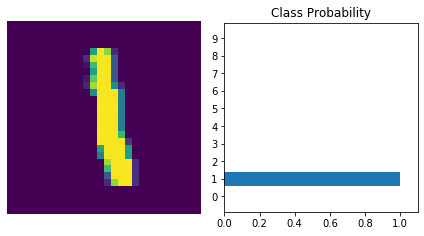

In [401]:
img = next(data).view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    ps = torch.exp(model(img))
helper.view_img_classify(img.view(1, 28, 28), ps)